# parallelised_stochastic_sampling
Implements parallelised stochastic sampling in arbitary dimensions for the following stochastic dynamics models:

1) Overdamped Langevin dynamics, $\overrightarrow{dX}_t = - \beta log \overrightarrow{\nabla} V(X_t)dt + \overrightarrow{dW}_t$

2) Anisotropic overdamped Langevin dynamics, $\overrightarrow{dX}_t =\left(- \mathbf{M}(\overrightarrow{X}_t)\overrightarrow{\nabla}V(X_t) + \beta^{-1} \overrightarrow{\nabla} \cdot \mathbf{M}(\overrightarrow{X}_t)\right)dt + \sqrt{2 \beta^{-1}}\mathbf{M}^{\frac{1}{2}}(\overrightarrow{X}_t) \overrightarrow{dW}_t$
3) Underdamped Langevin dyanamics, $\overrightarrow{dQ}_t = \overrightarrow{P}_t dt$, $\overrightarrow{dP}_t = \left(- \nabla V(\overrightarrow{Q}_t) - \gamma \overrightarrow{P}_t\right)dt + \sqrt{2M\gamma T} \overrightarrow{dW}_t$
4) Gaussian drift-diffusion dynamics with jumps $\overrightarrow{dX}_t = - \overrightarrow{\nabla} V(\overrightarrow{X}_t) + D \overrightarrow{dW}_t + \overrightarrow{J}_t(A, p)$, where $\overrightarrow{J}_t(A, p) = A \overrightarrow{N}_t$ with probability $1-p$ and $0$ otherwise and $\overrightarrow{N}_t$ is an isotropic standard multinormal random variable.

## Example 1:
### Stochastic Dynamics in a 1D Double-Well Potential

In [21]:
import autograd.numpy as np
from Langevin import OverdampedLangevin, UnderdampedLangevin, GaussianDriftDiffusion, AnisotropicOverdampedLangevin

First specify the functional form of the potential,

In [7]:
def double_well_potential(x):
    h = 2
    c = 2
    return -(1 / 4) * (x ** 2) * (h ** 4) + (1 / 2) * (c ** 2) * (x ** 4)

and initialise a stochastic dynamics object e.g.

In [8]:
od_ld = OverdampedLangevin(x0=0.0, potential=double_well_potential, beta=1, time_step=5e-3)
ud_ld = UnderdampedLangevin(Q0=0.0, P0=0.0, potential=double_well_potential, M=1, T=1, gamma=1, time_step=5e-3)
gdd = GaussianDriftDiffusion(x0=0.0, potential=double_well_potential, diffusion_coeff=1.0, jump_prob=0.05, jump_amplitude=0.03, time_step=5e-3)

note that $x_0, Q_0, P_0$ specify the initial coordinates of the chains (in this example all chains start at the origin).

Next run the sampling using the simulate method e.g. to simulate overdamped Langevin dynamics with chains of length 10,000:

In [9]:
traj = od_ld.simulate(length=10000)

Running 11 chains in parallel of length 10000.


100%|██████████| 10000/10000 [00:05<00:00, 1693.11it/s]


by default chains are run in parallel for each available CPU process.

Display the probability density of samples by using the plot method

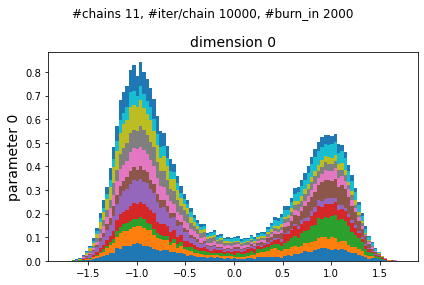

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'dimension 0'}, ylabel='parameter 0'>)

In [10]:
traj.plot()

note that by default chains are burnt-in and the visualisation neglects the first $N$ iteratitions (here $N=2000$).

Visualise the chains trajectories using the plot_trajectory method

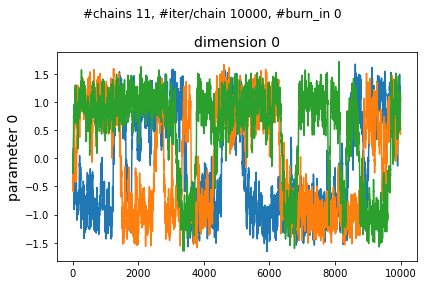

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'dimension 0'}, ylabel='parameter 0'>)

In [12]:
traj.set_burn_in(0)
traj.plot_trajectory(chains=[0,1,2])

here we choose to plot only the first three chains to avoid an overly-cluttered plot.

## Example 2:
### Stochastic Dynamics in a 2D Quadruple-Well Potential

First specify the functional form of the potential,

In [14]:
def quadruple_well_potential(x):
    h = 2
    c = 2
    return (-(1 / 4) * (x[0] ** 2) * (h ** 4) + (1 / 2) * (c ** 2) * (x[0] ** 4)) + (
            -(1 / 4) * (x[1] ** 2) * (h ** 4) + (1 / 2) * (c ** 2) * (x[1] ** 4))

and initialise a stochastic dynamics, specifying the number of spatial dimensions (2), e.g.

In [16]:
ud_ld = UnderdampedLangevin(spatial_dim = 2, muQ=[0.0, 0.0], muP=[0.0, 0.0], sigmaQ=[0.5, 0.5], sigmaP=[0.5, 0.5], potential=quadruple_well_potential, M=1, T=1, gamma=1, time_step=5e-3)

note this time we have randomised the chain initial conditions with specified position and momentum mean (muQ, muP) and standard deviation (sigmaQ, sigmaP) for each dimension.

Finally, run a stochastic simulation

In [17]:
traj = ud_ld.simulate(length=50000)

Running 11 chains in parallel of length 50000.


100%|██████████| 50000/50000 [00:48<00:00, 1040.59it/s]


optionally, we can modify the burn-in

In [18]:
traj.set_burn_in(5000)

and display the probability density of each parameter for each dimension using the plot method

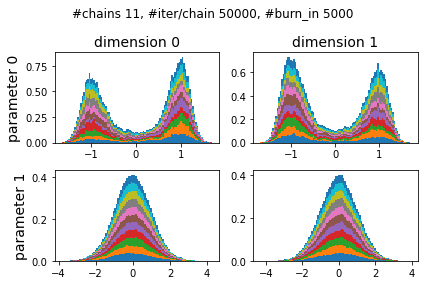

(<Figure size 432x288 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'dimension 0'}, ylabel='parameter 0'>,
         <AxesSubplot:title={'center':'dimension 1'}>],
        [<AxesSubplot:ylabel='parameter 1'>, <AxesSubplot:>]], dtype=object))

In [19]:
traj.plot()

note in the above plot, parameter 0 corresponds to $Q$ and parameter 1 corresponds to $P$.

## Example 3:
### Anisotropic Stochastic Dynamics in a 2D Moro-Cardin System

First specify the functional form of the potential,

In [22]:
def moro_cardin_potential(x):
    return 5 * (x[0] ** 2 - 1) ** 2 + 10 * np.arctan(7 * np.pi / 9) * x[1] ** 2

Since this will be anisotropic dynamics, we also need to specify the functional form of the diffusion matrix $\mathbf{M}(\overrightarrow{X}_t)$:

In [37]:
def moro_cardin_diffusion_matrix(x):
    return (1 + 8 * np.exp(- (x[0] ** 2 + x[1] ** 2) / (2 * 0.2 ** 2))) ** (-1) * np.eye(2)

Next we initialise the dynamics:

In [41]:
aod_ld = AnisotropicOverdampedLangevin(potential=moro_cardin_potential, diffusion_matrix=moro_cardin_diffusion_matrix, beta=1, time_step=0.001, x0=0.0, spatial_dim=2)

and run a stochastic simulation

In [42]:
traj = aod_ld.simulate(length=10000)

Running 11 chains in parallel of length 10000.


100%|██████████| 10000/10000 [00:20<00:00, 489.86it/s]


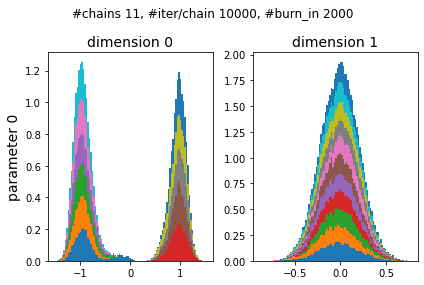

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'dimension 0'}, ylabel='parameter 0'>,
        <AxesSubplot:title={'center':'dimension 1'}>], dtype=object))

In [43]:
traj.plot()